In [67]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import spacy


In [68]:
# import os
# import csv

# # Define the directory where the files are located
# directory = 'mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv/'

# # Define the output CSV file name
# output_csv = 'mimic-iii-clinical-database-1.4/consolidated_diagnoses_icd.csv'

# # Initialize a list to store all rows
# rows = []

# # Define the header manually (based on your example)
# header = ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE']

# # Iterate through all files in the directory
# for filename in os.listdir(directory):
#     file_path = os.path.join(directory, filename)
    
#     # Skip directories, only process files
#     if os.path.isfile(file_path):
#         # Remove underscores and split the filename into components
#         clean_filename = filename.strip('_')  # Remove leading/trailing underscores
#         row_data = clean_filename.split('_')
        
#         # Append the row data to the rows list
#         rows.append(row_data)

# # Write the consolidated data to the output CSV file
# with open(output_csv, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
    
#     # Write the header
#     writer.writerow(header)
    
#     # Write all the rows
#     writer.writerows(rows)

# print(f"Consolidated CSV file saved to: {output_csv}")

In [69]:
# import csv

# # Define the input and output file paths
# input_csv = 'mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv'
# output_csv = 'mimic-iii-clinical-database-1.4/consolidated_diagnoses_icd.csv'

# # Initialize a list to store all rows
# rows = []

# # Open the improperly formatted CSV file
# with open(input_csv, 'r') as infile:
#     reader = csv.reader(infile)
    
#     # Read the header (first row)
#     header = next(reader)  # Assuming the first row contains the column names
    
#     # Iterate through each row in the file
#     for row in reader:
#         # Combine all elements in the row into a single string
#         combined_data = ''.join(row).strip()
        
#         # Split the combined data by commas
#         split_data = combined_data.split(',')
        
#         # Append the split data to the rows list
#         rows.append(split_data)

# # Write the corrected data to a new CSV file
# with open(output_csv, 'w', newline='') as outfile:
#     writer = csv.writer(outfile)
    
#     # Write the header
#     writer.writerow(header)
    
#     # Write all the rows
#     writer.writerows(rows)

# print(f"Corrected CSV file saved to: {output_csv}")

In [70]:
notes = pd.read_csv('mimic-iii-clinical-database-1.4/NOTEEVENTS.csv/NOTEEVENTS.csv')
diag = pd.read_csv('mimic-iii-clinical-database-1.4/DIAGNOSES_ICD/consolidated_diagnoses_icd.csv')
d_diag = pd.read_csv('mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv/D_ICD_DIAGNOSES.csv')
print(notes.head())
print(diag.head())
print(d_diag.head())

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
import pandas as pd
import spacy
from collections import Counter

# Step 2: Merge DataFrames on Admission ID (HADM_ID)
merged_df = pd.merge(notes, diag, on='HADM_ID')

# Step 3: Filter for Acute Kidney Injury (AKI)
# ICD9 codes for AKI: Acute kidney failure (584.x)
aki_codes = ['584']  # Base ICD9 code for AKI

# Drop rows where ICD9_CODE is NaN
merged_df = merged_df.dropna(subset=['ICD9_CODE'])

# Filter for rows where ICD9_CODE starts with any of the AKI codes
filtered_df = merged_df[merged_df['ICD9_CODE'].str.startswith(tuple(aki_codes))]

# Select the first 1000 rows and the 'TEXT' field
text_data = filtered_df['TEXT'].head(1000)  # Adjust the number of rows as needed


# Step 4: Load SpaCy with the Medium Model
nlp = spacy.load('en_core_web_md')  # Load SpaCy's medium English model


# Initialize a list to store extracted entities
all_entities = []

# Process each note entry using SpaCy
for note in text_data:
    doc = nlp(note)  # Create a SpaCy document
    for ent in doc.ents:  # Iterate through each entity in the document
        all_entities.append((ent.text, ent.label_))  # Append as a tuple

# Count occurrences of each entity
entity_counts = Counter(all_entities)

# Convert the counter to a DataFrame
entities_df = pd.DataFrame(entity_counts.items(), columns=['Entity_Label', 'Count'])

# Split the 'Entity_Label' column into separate 'Entity' and 'Label' columns
entities_df[['Entity', 'Label']] = pd.DataFrame(entities_df['Entity_Label'].tolist(), index=entities_df.index)

# Drop the combined 'Entity_Label' column
entities_df = entities_df.drop(columns=['Entity_Label'])

# Sort the DataFrame by 'Count' in descending order
entities_df = entities_df.sort_values(by='Count', ascending=False)

# Save the extracted entities with counts to a CSV file
entities_df.to_csv('extracted_entities_aki_spacy_with_counts.csv', index=False)

print("Entities extracted, counted, and saved to 'extracted_entities_aki_spacy_with_counts.csv'")

Entities extracted, counted, and saved to 'extracted_entities_aki_spacy_with_counts.csv'


In [ ]:
filtered_df

,ROW_ID_x,SUBJECT_ID_x,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ROW_ID_y,SUBJECT_ID_y,SEQ_NUM,ICD9_CODE
14,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...,153666,13702,2.0,5849
35,185,1136,139574.0,2192-05-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2192-4-19**] ...,13155,1136,1.0,5849
106,231,9805,177212.0,2131-07-05,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2131-6-28**] ...,109848,9805,5.0,5849
117,232,9805,177212.0,2131-07-23,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2131-7-5**] D...,109848,9805,5.0,5849
367,17,15472,109655.0,2177-12-05,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2177-11-25**] Discha...,172229,15472,3.0,5849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503540,371604,3722,107462.0,2149-03-29,2149-03-29 07:11:00,2149-03-29 12:10:03,Physician,Physician Resident Progress Note,21507.0,NaN,Chief Complaint:\n 24 Hour Events:\n Patie...,41190,3722,8.0,5849
5503554,371616,1578,127454.0,2141-02-25,2141-02-25 07:39:00,2141-02-25 15:31:54,Physician,Physician Resident Progress Note,19697.0,NaN,Chief Complaint:\n 24 Hour Events:\n NON-INV...,17748,1578,4.0,5849
5503571,371955,3722,107462.0,2149-04-01,2149-04-01 07:24:00,2149-04-01 07:24:58,Physician,Physician Resident Progress Note,21507.0,NaN,Chief Complaint:\n 24 Hour Events:\n - abl...,41190,3722,8.0,5849
5503589,371960,3722,107462.0,2149-04-01,2149-04-01 07:24:00,2149-04-01 07:42:04,Physician,Physician Resident Progress Note,21507.0,NaN,Chief Complaint:\n 24 Hour Events:\n - Som...,41190,3722,8.0,5849


In [ ]:

from spacy import displacy

doc = nlp(text_data[14])
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
# Step 4: Load SciSpaCy with the Medium Model
nlp = spacy.load('en_core_sci_md')  # Load SciSpaCy's medium English model for scientific text

# Step 5: Extract Text and Process Entities
# Select the first 1000 rows and the 'TEXT' field
text_data = filtered_df['TEXT'].head(1000)  # Adjust the number of rows as needed

# Initialize a list to store extracted entities
all_entities = []

# Process each note entry using SciSpaCy
for note in text_data:
    doc = nlp(note)  # Create a SciSpaCy document
    for ent in doc.ents:  # Iterate through each entity in the document
        all_entities.append((ent.text, ent.label_))  # Append as a tuple

# Count occurrences of each entity
entity_counts = Counter(all_entities)

# Convert the counter to a DataFrame
entities_df = pd.DataFrame(entity_counts.items(), columns=['Entity_Label', 'Count'])

# Split the 'Entity_Label' column into separate 'Entity' and 'Label' columns
entities_df[['Entity', 'Label']] = pd.DataFrame(entities_df['Entity_Label'].tolist(), index=entities_df.index)

# Drop the combined 'Entity_Label' column
entities_df = entities_df.drop(columns=['Entity_Label'])

# Sort the DataFrame by 'Count' in descending order
entities_df = entities_df.sort_values(by='Count', ascending=False)

# Save the extracted entities with counts to a CSV file
entities_df.to_csv('extracted_entities_aki_scispacy_with_counts.csv', index=False)

print("Entities extracted, counted, and saved to 'extracted_entities_aki_scispacy_with_counts.csv'")

c:\Users\leon1\anaconda3\envs\mimic\Lib\site-packages\spacy\language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


Entities extracted, counted, and saved to 'extracted_entities_aki_scispacy_with_counts.csv'


In [ ]:
doc = nlp(text_data[14])
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')
# Tokenize the text
nltk.download('punkt')
tokenized_reports = [word_tokenize(report.lower()) for report in text_data]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_reports, vector_size=100, window=5, min_count=2, workers=4)



[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\leon1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leon1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
word_embeddings = [model.wv[word] for sentence in tokenized_reports for word in sentence if word in model.wv.key_to_index]

In [ ]:
# Example usage for finding similar words related to acute kidney injury
terms_to_check = [
    "acute kidney injury",  # The primary term of interest
    "renal failure",        # A broader term for kidney dysfunction
    "kidney damage",        # Another term for kidney-related issues
    "creatinine",           # A biomarker for kidney function
    "uremia",               # A condition caused by kidney dysfunction
    "oliguria",             # Reduced urine output, often seen in AKI
    "nephrotoxicity",       # Toxicity causing kidney damage
    "dialysis",             # A treatment for severe kidney failure
    "fluid overload",       # A complication of kidney dysfunction
    "hypertension"          # Often associated with kidney disease
]

for term in terms_to_check:
    try:
        similar_words = model.wv.most_similar(term)
        print(f"Words similar to '{term}': {similar_words}\n")
    except KeyError:
        print(f"Term '{term}' not found in the model vocabulary.\n")

Term 'acute kidney injury' not found in the model vocabulary.

Term 'renal failure' not found in the model vocabulary.

Term 'kidney damage' not found in the model vocabulary.

Words similar to 'creatinine': [('cr', 0.8422286510467529), ('bun', 0.7181711196899414), ('creat', 0.7177120447158813), ('2.2', 0.698356568813324), ('rising', 0.6969766616821289), ('trended', 0.6946861147880554), ('lactate', 0.6912423372268677), ('hematocrit', 0.6822028756141663), ('down', 0.6815913319587708), ('1.3', 0.6791064739227295)]

Words similar to 'uremia': [('encephalopathy', 0.8204140067100525), ('toxic', 0.8030644059181213), ('multifactorial', 0.7986410856246948), ('delirium', 0.7977501153945923), ('somnolence', 0.7895799279212952), ('hyponatremia', 0.7848168611526489), ('ards', 0.7739786505699158), ('metabolic', 0.768686056137085), ('acidosis', 0.7685164213180542), ('acidemia', 0.7641879916191101)]

Words similar to 'oliguria': [('obtundation', 0.8046311140060425), ('hypoxemic', 0.7941254377365112),

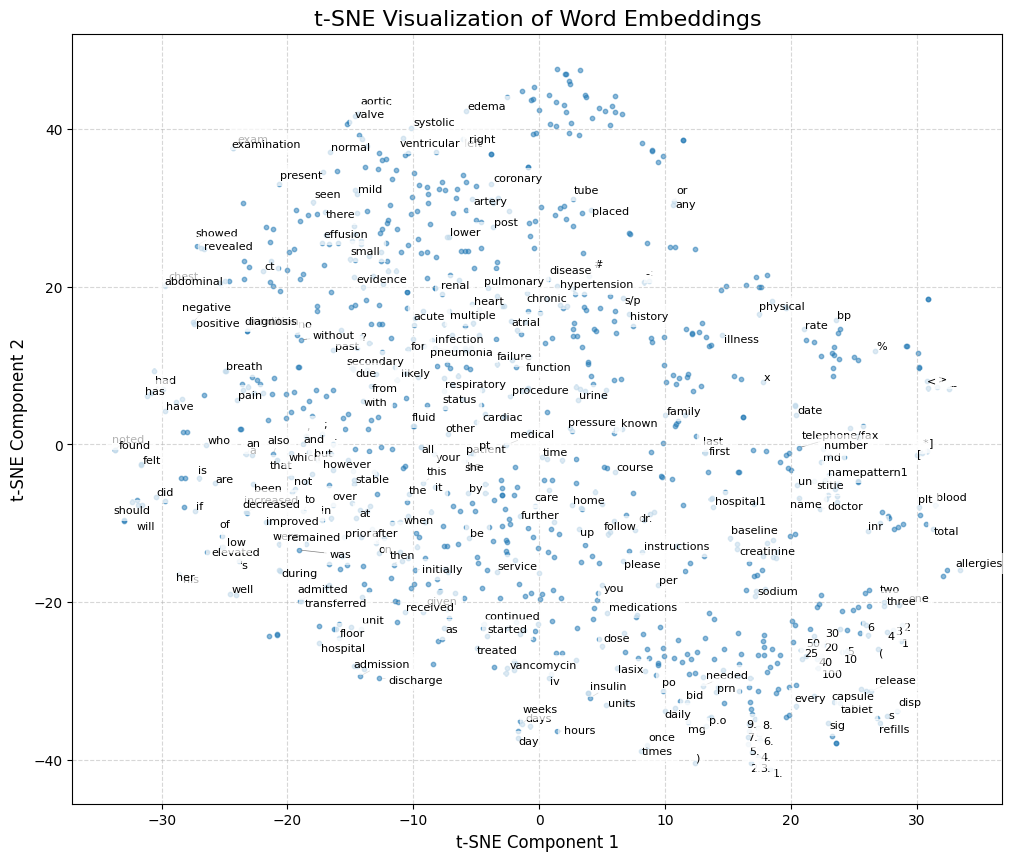

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text  # Auto-adjusts overlapping text

# Get word vectors
words = list(model.wv.index_to_key)
vectors = np.array([model.wv[word] for word in words[:1000]])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_vectors = tsne.fit_transform(vectors)

# Plot
plt.figure(figsize=(12, 10))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.5, marker='o', s=10)

# Annotate with adjusted text
texts = []
for i, word in enumerate(words[:250]):
    texts.append(plt.text(
        reduced_vectors[i, 0], reduced_vectors[i, 1], word, 
        fontsize=8, color='black', alpha=1.0, 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')  # Background for better contrast
    ))

# Auto-adjust labels to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

plt.title("t-SNE Visualization of Word Embeddings", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load ClinicalBERT
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model_clinicalbert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Function to get ClinicalBERT embeddings
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():  # Disable gradient computation for efficiency
        outputs = model_clinicalbert(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()  # Get sentence-level embedding



# Compute embeddings
embeddings = np.vstack([get_embedding(note) for note in text_data[:10]])

# Compute cosine similarity
similarity_matrix = cosine_similarity(embeddings)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, columns=[f"Note {i+1}" for i in range(10)], index=[f"Note {i+1}" for i in range(10)])

# Display similarity matrix
print(similarity_df)


c:\Users\leon1\anaconda3\envs\mimic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


           Note 1    Note 2    Note 3    Note 4    Note 5    Note 6    Note 7  \
Note 1   1.000000  0.970143  0.974409  0.968130  0.972503  0.965108  0.968486   
Note 2   0.970143  1.000000  0.987374  0.985717  0.960648  0.983356  0.979074   
Note 3   0.974409  0.987374  1.000000  0.993065  0.969021  0.971386  0.985427   
Note 4   0.968130  0.985717  0.993065  1.000000  0.962754  0.970528  0.980408   
Note 5   0.972503  0.960648  0.969021  0.962754  1.000000  0.968330  0.952751   
Note 6   0.965108  0.983356  0.971386  0.970528  0.968330  1.000000  0.954924   
Note 7   0.968486  0.979074  0.985427  0.980408  0.952751  0.954924  1.000000   
Note 8   0.982712  0.980846  0.980527  0.976860  0.977434  0.981751  0.966969   
Note 9   0.958244  0.956956  0.966777  0.971483  0.954774  0.942902  0.952882   
Note 10  0.957918  0.963956  0.959017  0.963022  0.962173  0.971225  0.946081   

           Note 8    Note 9   Note 10  
Note 1   0.982712  0.958244  0.957918  
Note 2   0.980846  0.956956 

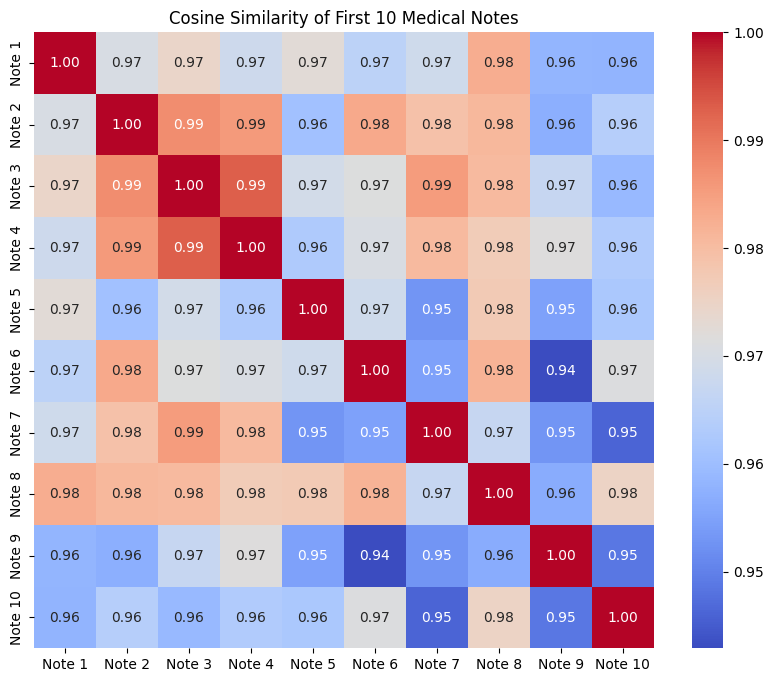

In [ ]:

import seaborn as sns
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity of First 10 AKI Notes")
plt.show()

In [ ]:
# Define the ICD-9 codes for similar and different injuries
similar_injury_codes = ['586']
different_injury_codes = ['123']

# Filter for similar injuries
similar_injuries_df = merged_df[merged_df['ICD9_CODE'].str.startswith(tuple(similar_injury_codes))]

# Filter for completely different injuries
different_injuries_df = merged_df[merged_df['ICD9_CODE'].str.startswith(tuple(different_injury_codes))]

# Combine the filtered dataframes if needed
combined_df = pd.concat([similar_injuries_df, different_injuries_df])

# Select the 'TEXT' field for analysis
text_data_similar = similar_injuries_df['TEXT'].head(3)  # First 1000 rows for similar injuries
text_data_different = different_injuries_df['TEXT'].head(3)  # First 1000 rows for different injuries

# Print some statistics
print("Number of similar injury records:", len(similar_injuries_df))
print("Number of different injury records:", len(different_injuries_df))

Number of similar injury records: 10
Number of different injury records: 23


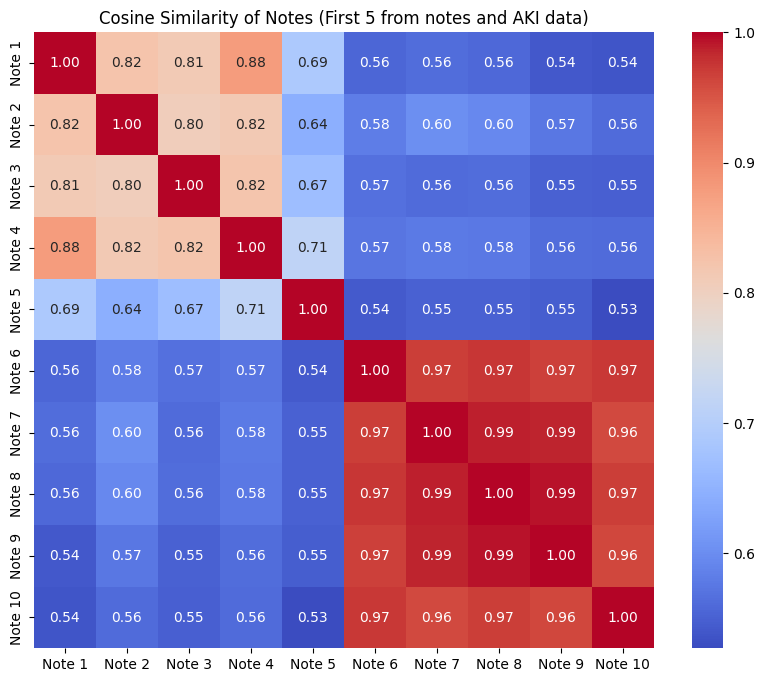

In [ ]:
# Extract first 5 notes from both datasets
random = notes['TEXT'].iloc[0][:5]  # First 5 notes from 'notes' dataset

# Combine both sets of notes into one list
all_notes = list(random) + list(text_data[:5])

# Compute embeddings
embeddings = np.vstack([get_embedding(note) for note in all_notes])

# Compute cosine similarity
similarity_matrix = cosine_similarity(embeddings)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, columns=[f"Note {i+1}" for i in range(10)], index=[f"Note {i+1}" for i in range(10)])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity of Notes (First 5 from notes and 6 - 10 AKI notes)")
plt.show()

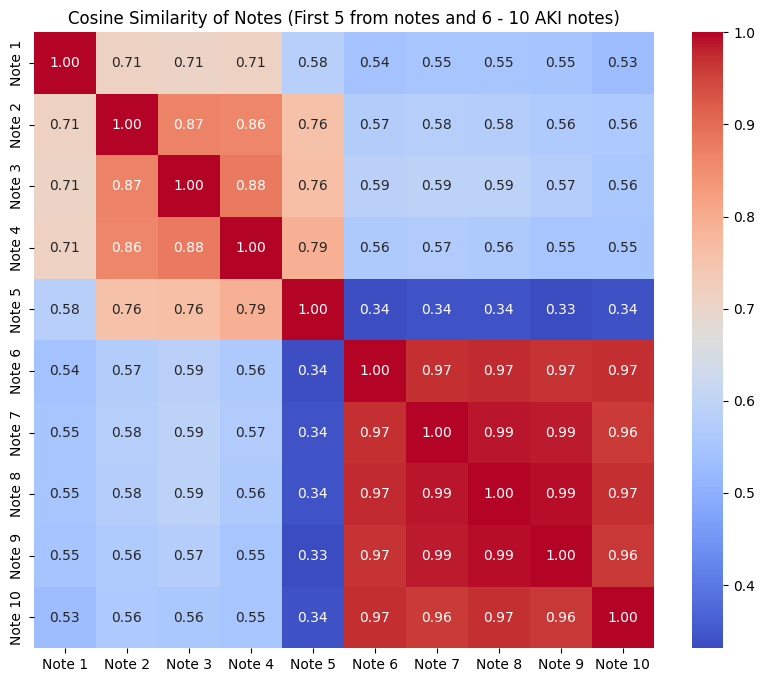

In [76]:
# Extract first 5 notes from both datasets
random = merged_df['TEXT'].iloc[0][5:10]  # First 5 notes from 'notes' dataset

# Combine both sets of notes into one list
all_notes = list(random) + list(text_data[:5])

# Compute embeddings
embeddings = np.vstack([get_embedding(note) for note in all_notes])

# Compute cosine similarity
similarity_matrix = cosine_similarity(embeddings)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, columns=[f"Note {i+1}" for i in range(10)], index=[f"Note {i+1}" for i in range(10)])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity of Notes (First 5 from notes and 6 - 10 AKI notes)")
plt.show()

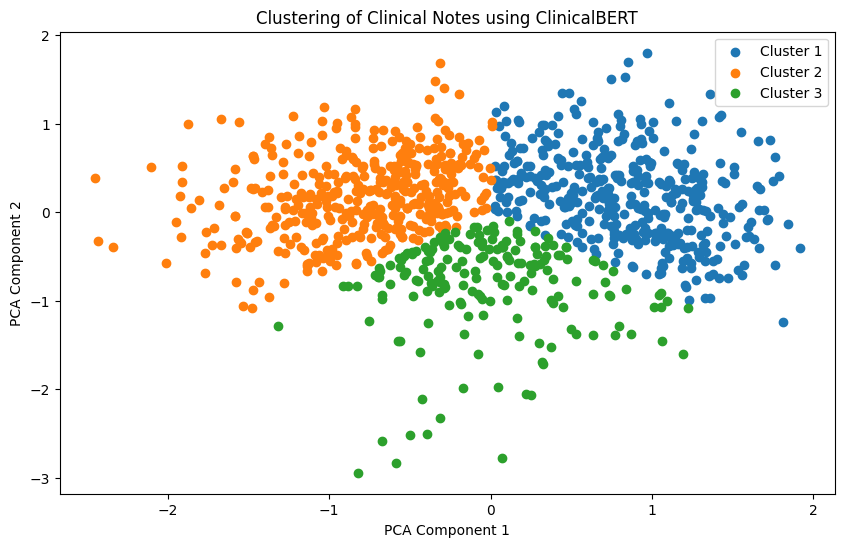

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Convert text data into embeddings
embeddings = np.vstack([get_embedding(note) for note in text_data])

# Reduce dimensionality using PCA for better clustering
pca = PCA(n_components=2)  # Reduce to 2D for visualization
reduced_embeddings = pca.fit_transform(embeddings)

# Apply K-Means clustering
num_clusters = 3  # Adjust based on expected categories
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(reduced_embeddings)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    plt.scatter(reduced_embeddings[labels == i, 0], reduced_embeddings[labels == i, 1], label=f"Cluster {i+1}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustering of Clinical Notes using ClinicalBERT")
plt.legend()
plt.show()

In [ ]:
print(notes.head(10))

   ROW_ID  SUBJECT_ID   HADM_ID   CHARTDATE CHARTTIME STORETIME  \
0     174       22532  167853.0  2151-08-04       NaN       NaN   
1     175       13702  107527.0  2118-06-14       NaN       NaN   
2     176       13702  167118.0  2119-05-25       NaN       NaN   
3     177       13702  196489.0  2124-08-18       NaN       NaN   
4     178       26880  135453.0  2162-03-25       NaN       NaN   
5     179       53181  170490.0  2172-03-08       NaN       NaN   
6     180       20646  134727.0  2112-12-10       NaN       NaN   
7     181       42130  114236.0  2150-03-01       NaN       NaN   
8     182       56174  163469.0  2118-08-12       NaN       NaN   
9     183       56174  189681.0  2118-12-09       NaN       NaN   

            CATEGORY DESCRIPTION  CGID  ISERROR  \
0  Discharge summary      Report   NaN      NaN   
1  Discharge summary      Report   NaN      NaN   
2  Discharge summary      Report   NaN      NaN   
3  Discharge summary      Report   NaN      NaN   
4  Disc

In [ ]:
print(filtered_df.head(10))

     ROW_ID_x  SUBJECT_ID_x   HADM_ID   CHARTDATE CHARTTIME STORETIME  \
14        177         13702  196489.0  2124-08-18       NaN       NaN   
35        185          1136  139574.0  2192-05-23       NaN       NaN   
106       231          9805  177212.0  2131-07-05       NaN       NaN   
117       232          9805  177212.0  2131-07-23       NaN       NaN   
367        17         15472  109655.0  2177-12-05       NaN       NaN   
421        21         15472  188190.0  2178-12-09       NaN       NaN   
516        36          5458  130840.0  2137-03-16       NaN       NaN   
535        44         13733  196357.0  2143-04-26       NaN       NaN   
625        80          3506  140045.0  2195-05-28       NaN       NaN   
634        81          3506  140045.0  2195-05-28       NaN       NaN   

              CATEGORY DESCRIPTION  CGID  ISERROR  \
14   Discharge summary      Report   NaN      NaN   
35   Discharge summary      Report   NaN      NaN   
106  Discharge summary      Report   

In [ ]:
unique_descriptions = notes["CATEGORY"].unique()
print(unique_descriptions)


['Discharge summary' 'Echo' 'ECG' 'Nursing' 'Physician ' 'Rehab Services'
 'Case Management ' 'Respiratory ' 'Nutrition' 'General' 'Social Work'
 'Pharmacy' 'Consult' 'Radiology' 'Nursing/other']


In [ ]:
from sklearn.preprocessing import StandardScaler
# Select first 1000 rows
text_sample = filtered_df[['TEXT', 'CATEGORY']].head(1000).copy()

# Compute embeddings for these 1000 rows
text_sample["Embeddings"] = text_sample["TEXT"].apply(get_embedding)

# Convert embeddings to a NumPy array
embeddings = np.vstack(text_sample["Embeddings"].values)

# Standardize embeddings before clustering
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
text_sample["Cluster"] = kmeans.fit_predict(embeddings_scaled)

# Now `text_sample` has clusters assigned correctly


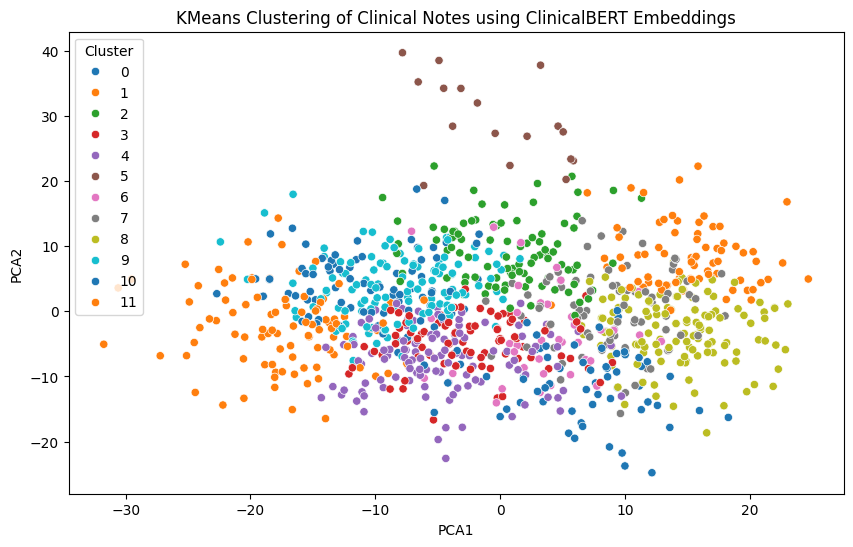

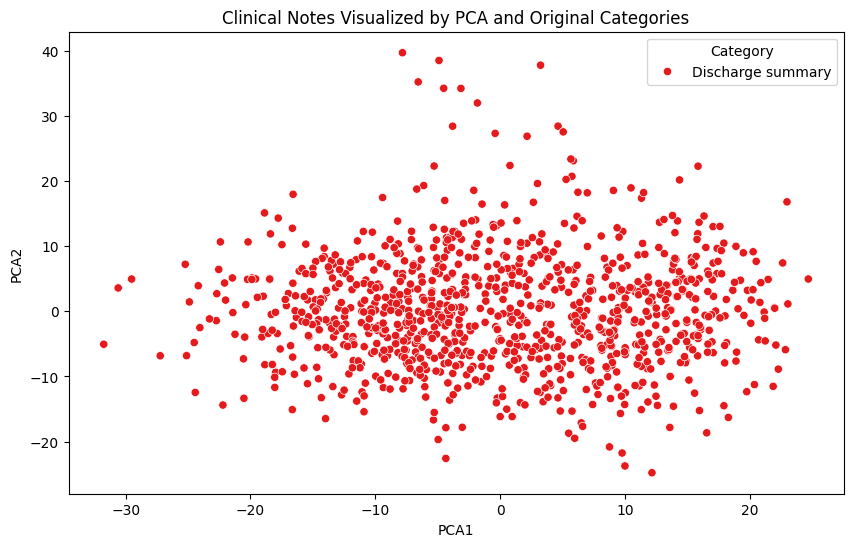

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_scaled)

# Add PCA results to DataFrame
text_sample["PCA1"] = reduced_embeddings[:, 0]
text_sample["PCA2"] = reduced_embeddings[:, 1]

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue=text_sample["Cluster"], palette="tab10", data=text_sample)
plt.title("KMeans Clustering of Clinical Notes using ClinicalBERT Embeddings")
plt.legend(title="Cluster")
plt.show()
# Scatter plot based on original categories
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue=text_sample["CATEGORY"], palette="Set1", data=text_sample)
plt.title("Clinical Notes Visualized by PCA and Original Categories")
plt.legend(title="Category")
plt.show()



In [ ]:
# Compare predicted clusters with actual categories
print(pd.crosstab(text_sample["Cluster"], text_sample["CATEGORY"]))


CATEGORY  Discharge summary
Cluster                    
0                        61
1                        95
2                        92
3                        89
4                       116
5                        17
6                        40
7                        80
8                       130
9                       124
10                       82
11                       74


In [ ]:
import pandas as pd

# Step 1: Merge DataFrames on Admission ID (HADM_ID)
merged_df = pd.merge(notes, diag, on='HADM_ID')

# Step 2: Filter for Acute Kidney Injury (AKI)
# ICD9 codes for AKI: Acute kidney failure (584.x)
aki_codes = ['584']  # Base ICD9 code for AKI

# Drop rows where ICD9_CODE is NaN
merged_df = merged_df.dropna(subset=['ICD9_CODE'])

# Filter for rows where ICD9_CODE starts with any of the AKI codes
filtered_df = merged_df[merged_df['ICD9_CODE'].str.startswith(tuple(aki_codes))]

# Select the first 1000 rows and the 'TEXT' field for AKI notes
text_data = filtered_df['TEXT'].head(1000)  # Adjust the number of rows as needed

# Step 3: Extract Non-AKI Notes
# Filter for non-AKI notes (exclude rows where ICD9_CODE starts with '584')
non_aki_df = merged_df[~merged_df['ICD9_CODE'].str.startswith(tuple(aki_codes))]

# Select the first 1000 non-AKI rows and the 'TEXT' field
non_aki_text_data = non_aki_df['TEXT'].head(1000)  # Adjust the number of rows as needed

# Step 4: Label the Data
# Create labels for AKI and non-AKI notes
aki_labels = [1] * len(text_data)  # Labels for AKI notes
non_aki_labels = [0] * len(non_aki_text_data)  # Labels for non-AKI notes

# Combine AKI and non-AKI text data
all_text_data = pd.concat([text_data, non_aki_text_data])

# Combine AKI and non-AKI labels
all_labels = aki_labels + non_aki_labels

# Step 5: Combine the Data into a Single DataFrame
# Combine text data and labels into a single DataFrame
labeled_data = pd.DataFrame({
    'TEXT': all_text_data,
    'LABEL': all_labels
})

# Shuffle the data to mix AKI and non-AKI examples
labeled_data = labeled_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows of the labeled dataset
print(labeled_data.head())

                                                TEXT  LABEL
0  Admission Date:  [**2158-1-5**]              D...      0
1  Admission Date:  [**2132-7-24**]              ...      1
2  Admission Date:  [**2175-7-11**]     Discharge...      0
3  Admission Date:  [**2151-7-3**]              D...      1
4  Admission Date:  [**2152-2-15**]              ...      0


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load Clinical BERT tokenizer and model with a classification head
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import Dataset, DataLoader

# Create a custom dataset
class NoteDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Set maximum sequence length
MAX_LENGTH = 512

# Create dataset and dataloader
dataset = NoteDataset(text_data, labels, tokenizer, MAX_LENGTH)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
import torch

# Step 1: Merge DataFrames on Admission ID (HADM_ID)
merged_df = pd.merge(notes, diag, on='HADM_ID')

# Step 2: Filter for Acute Kidney Injury (AKI)
aki_codes = ['584']  # Base ICD9 code for AKI
merged_df = merged_df.dropna(subset=['ICD9_CODE'])
filtered_df = merged_df[merged_df['ICD9_CODE'].str.startswith(tuple(aki_codes))]

# Step 3: Extract Non-AKI Notes
non_aki_df = merged_df[~merged_df['ICD9_CODE'].str.startswith(tuple(aki_codes))]

# Select the first 1000 rows for both AKI and non-AKI notes
text_data = pd.concat([filtered_df['TEXT'].head(1000), non_aki_df['TEXT'].head(1000)])
all_labels = [1] * 1000 + [0] * 1000

# Reset indices to avoid KeyErrors
text_data = text_data.reset_index(drop=True)

# Step 4: Define Dataset Class
class NoteDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx] if isinstance(self.texts, pd.Series) else self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Step 5: Tokenize and Create DataLoader
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
dataset = NoteDataset(text_data, all_labels, tokenizer, max_length=512)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Step 6: Load Model and Train
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3

for epoch in range(epochs):
    total_loss = 0
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Get predicted class
            preds = torch.argmax(logits, dim=1)
            
            # Store predictions and true labels
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy:.4f}")
    return predictions, true_labels

# Evaluate the model
predictions, true_labels = evaluate_model(model, dataloader, device)

In [ ]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("./fine_tuned_clinical_bert_aki")
tokenizer.save_pretrained("./fine_tuned_clinical_bert_aki")